---
highlight-style:
  light: arrow.theme
  dark: arrow-dark.theme
format:
  html:
    code-line-numbers: false
---



# Linear Programming {#sec-linear}

In this chapter, we first go through the modeling capabilities provided by Google OR-Tools to solve linear programming problems.
Then we get our hands dirty by solving some linear programming problems.

## Modeling Capabilities

There are three components in a mathematical model, namely, decision varaibles, constraints and objective, for which we will go over in the following sections.

### Solver

In Google OR-Tools, a `Solver` instance must be created first so that variables, constraints and objective can be added to it.
The `Solver` class is defined in the `ortools.linear_solver.pywraplp` module and it requires a solver id to instantiate an object.
In the code snippet below, the required module is imported first and a `solver` object is created with `GLOP`, Google's own optimization engine for solving linear programming problems.
It is good practice to verify whether the desired solver is indeed created successfully or not.

In [59]:
from ortools.linear_solver import pywraplp

solver = pywraplp.Solver.CreateSolver("GLOP")

if solver:
    print("solver creation success!")
else:
    print("solver creation failure!")

solver creation success!


### Decision Variables

The `Solver` class defines a number of ways to create decision variables:

1. `Var(lb, ub, integer, name)`
2. `NumVar(lb, ub, name)`
3. `IntVar(lb, ub, name)`
4. `BoolVar(name)`

- Function `Var()`

The `Var()` method is the most flexible way to define variables, as it can be used to create numerical, integral and boolean variables.
In the following code, a numerical variable named 'var1' is created with bound (0.0, 1.0).
Note that the parameter `integer` is set to `False` in the call to function `Var()`.

In [60]:
var1 = solver.Var(lb=0, ub=1.0, integer=False, name="var1")

We could create an integer variable using the same function:

In [61]:
var2 = solver.Var(lb=0, ub=1.0, integer=True, name="var2")

- Function `NumVar()`

`var1` could be creatd alternatively using the specialized function `NumVar()`:

In [62]:
var1 = solver.NumVar(lb=0, ub=1.0, name='var1')

- Function `IntVar()`

Similarly, `var2` could be created alternatively using the specialized function `IntVar()`:

In [63]:
var2 = solver.IntVar(lb=0, ub=1.0, name='var2')

- Function `BoolVar()`

A boolean variable could be created using the `BoolVar()` function:

In [64]:
var3 = solver.BoolVar(name='var3')

### Constraints

Constraints limit the solution space of an optimization problem, and there are two ways to define constraints in Google OR-Tools.
In the first approach, we could use the `Add()` function to create a constraint and automatically add it to the model at the same time, as the below code snippet illustrates.

In [65]:
cons1 = solver.Add(constraint=var1 + var2 <= 1, name="cons1")

type(cons1)

ortools.linear_solver.pywraplp.Constraint

Note that the `Add()` function returns an object of the `Constraint` class defined in the `pywraplp` module, as shown in the code output.
It is a good practice to retain the reference of the newly created constraint, as we might want to query its information later on.

The second approach works in a slightly different way. It starts with an empty constraint, with potential lower bound and upper bounds provided, and add components of the constraint gradually.
The code snippet below shows an example of adding a second constraint to the model.
In this approach, we must retain the reference to the constraint, as it is needed to add decision variables to the constraint in following steps.

In [66]:
cons2 = solver.Constraint(-solver.infinity(), 10.0, "cons2")
cons2.SetCoefficient(var1, 2)
cons2.SetCoefficient(var2, 3)
cons2.SetCoefficient(var3, 4)
type(cons2)

ortools.linear_solver.pywraplp.Constraint

### Objective

Similar to constraints, there are two ways to define the objective in Google OR-Tools.
In the first approach, we directly add an objective to the model by using the `Maximize()` or `Minimize()` function.
Below is an example:



In [67]:
solver.Minimize(var1 + var2 + var3)

Note that the function itself does not return a reference to the newly created objective function, but we could use a dedicated function to retrive it:

In [68]:
obj = solver.Objective()
print(obj)

<ortools.linear_solver.pywraplp.Objective; proxy of <Swig Object of type 'operations_research::MPObjective *' at 0x10815d9b0> >


In the second approach, we build the objective incrementally, just as in the second approach of creating constraints.
Specifically, we start with an empty objective function, and gradually add components to it.
In the end, we specify the optimization sense - whether we want to maximize or minimnize the objective.

In [69]:
obj = solver.Objective()
obj.SetCoefficient(var1, 1.0)
obj.SetCoefficient(var2, 1.0)
obj.SetCoefficient(var3, 1.0)
obj.SetMinimization()
print(obj)

<ortools.linear_solver.pywraplp.Objective; proxy of <Swig Object of type 'operations_research::MPObjective *' at 0x10815dc20> >


### Objective and Constraint Expressions

When we build constraints or objective functions, sometimes they comprise of complex expressions that we would like to build incrementally, possibly within loops.
For example, we might have a mathematical expression of the form $expr = 2x_1 + 3x_2 + 4x_3 + x_4$, which could be part of the objective function or any constraints.
In this case, we can either use the aforementioned `SetCoefficient()` function to add each element of the expression to the constraint or objective, or we could build an expression first and add it once in the end.
The code snippet below shows an example.

In [70]:
infinity = solver.Infinity()
x1 = solver.NumVar(0, infinity, name="x1")
x2 = solver.NumVar(0, infinity, name="x2")
x3 = solver.NumVar(0, infinity, name="x3")
x4 = solver.NumVar(0, infinity, name="x4")

expr = []
expr.append(2 * x1)
expr.append(3 * x2)
expr.append(4 * x3)
expr.append(x4)

cons = solver.Add(solver.Sum(expr) <= 10)
print(cons)

solver.Minimize(solver.Sum(expr))

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x10815c5d0> >


Of course, it is not obvious here that the retitive calls to the `append()` method are any more convenient than the `SetCoefficient()` method.
Let's say that we have a slightly more complex expression of the form $\sum_{0 \le i < 4}w_i \cdot x_i$, now we could build the expression using a loop:

In [71]:
w = [2, 3, 4, 1]
x = [x1, x2, x3, x4]
expr = []
for i in range(4):
    expr.append(w[i] * x[i])

cons = solver.Add(solver.Sum(expr) <= 10)

### Query the Model

After we build the model, we can query it using some helper functions.
For example, to get the total number of constraints, we use the `NumVariables()` function.
In a similar fashion, we can retrieve the total number of constraints with the `NumConstraints()` function.

In [72]:
num_vars = solver.NumVariables()
print(f"there are a total of {num_vars} variables in the model")

num_cons = solver.NumConstraints()
print(f"there are a total of {num_cons} constraints in the model")

there are a total of 9 variables in the model
there are a total of 4 constraints in the model


## Applications

In this section, we use some examples to showcase the modeling capability of Google OR-Tools.

### A Trivial Example

We now consider an simple linear programming problem with two decision variables $x$ and $y$.
The formal mathematical model is defined as below:


\begin{align}
\text{max.} \quad & x + 2y \\
\text{s.t.} \quad & x + y \le 10 \\
& x >= 1 \\
& y >= 1
\end{align}


@fig-lp-example shows the three defining constraints represented in blue lines and the feasible space depicted by the orange shaded area.
The objective function is indicated by the red dashed lines.
It can be seen from the figure that the point in green circle gives the maximal objective value of 19.

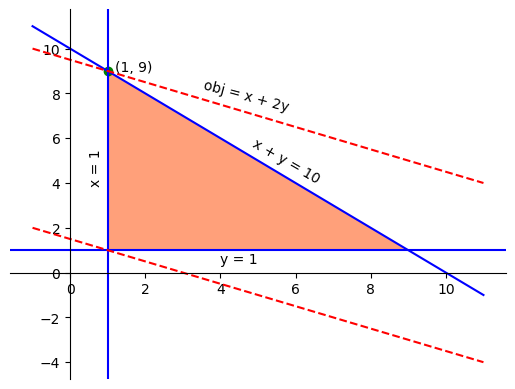

In [193]:
#| echo: false
#| fig-cap: A simple LP example
#| label: fig-lp-example
import matplotlib.pyplot as plt
import numpy as np

# setup axis
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# plot three constraints
x = np.linspace(-1, 11)
y = 10 - x
plt.plot(x, y, 'b')
plt.axvline(x = 1, color = 'b')
plt.axhline(y = 1, color = 'b')

# add annotations
ax.annotate('y = 1', xy=(4, 0.4))
ax.annotate('x = 1', xy=(0.5, 4), rotation=90)
ax.annotate('x + y = 10', xy=(4.8, 4), rotation=-30)

# show the feasible space
corners_x = np.array([1, 9, 1])
corners_y = np.array([1, 1, 9])
plt.fill(corners_x, corners_y, facecolor='lightsalmon')

# add objective function
obj_x = np.linspace(-1, 11)
obj_y = 9.5 - 0.5 * obj_x
plt.plot(obj_x, obj_y, 'r--')
ax.annotate('obj = x + 2y', xy=(3.5, 7.2), rotation=-15)
ax.annotate('(1, 9)', xy=(1.2, 9))
plt.scatter(1, 9, marker="o", c='g')


obj_x = np.linspace(-1, 11)
obj_y = 1.5 - 0.5 * obj_x
plt.plot(obj_x, obj_y, 'r--')
# ax.annotate('x + 2y = 19', xy=(4.5, 6.5), rotation=-20)

# show the figure
plt.show()

Let's now use Google OR-Tools to model and solve this problem.
The code snippet below shows the complete program.

In [201]:
# import Google OR-Tools library
from ortools.linear_solver import pywraplp

# create a solver
solver = pywraplp.Solver.CreateSolver("GLOP")

# create decision variables
x = solver.NumVar(1.0, solver.Infinity(), 'x')
y = solver.NumVar(1.0, solver.Infinity(), 'y')

# create constraints
cons = solver.Add(x + y <= 10)

# create objective
solver.Maximize(x + 2 * y)

# solve the problem
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
    print(f"obj = {solver.Objective().Value()}")
    print(f"x = {x.solution_value()}, reduced cost = {x.reduced_cost()}")
    print(f"y = {y.solution_value()}, reduced cost = {y.reduced_cost()}")
    print(f"cons dual value = {cons.dual_value()}")

obj = 19.0
x = 1.0, reduced cost = -1.0
y = 9.0, reduced cost = 0.0
cons dual value = 2.0


We can see from the output that the optimal solution is $x = 1.0$ and $y = 9.0$, and the optimal objective is 19.0.
This can also be validated from @fig-lp-example that the optimal solution is exactly the green point that sits at the intersection of the three lines $x = 1$, $x + y = 10$ and $x + 2y = 19$.

@fig-lp-example also shows that the point (1, 1) should give us the minimal value of the objective function.
To validate this, we can actually change the optimization sense of the objective function from maximization to minimization using the function `SetOptimizationDirection()`, as shown in the code below:

In [202]:
solver.Objective().SetOptimizationDirection(maximize=False)

solver.Solve()

print(f"obj = {solver.Objective().Value()}")
print(f"x = {x.solution_value()}, reduced cost = {x.reduced_cost()}")
print(f"y = {y.solution_value()}, reduced cost = {y.reduced_cost()}")
print(f"cons dual value = {cons.dual_value()}")

obj = 3.0
x = 1.0, reduced cost = 1.0
y = 1.0, reduced cost = 2.0
cons dual value = 0.0


### The Transportation Problem

In [212]:
#| echo: false
#| label: tbl-planet-measures
#| tbl-cap: A transportation problem

from IPython.display import Markdown
from tabulate import tabulate
import random

random.seed(42)

cost_matrix = [["S1"],
         ["S2"],
         ["S3"],
         ["S4"]]
for row in cost_matrix:
  row.extend([random.randint(1, 10) for _ in range(5)])
Markdown(tabulate(
  cost_matrix, 
  headers=[" ","D1", "D2", "D3", "D4", "D5"]
))

       D1    D2    D3    D4    D5
---  ----  ----  ----  ----  ----
S1      2     1     5     4     4
S2      3     2     9     2    10
S3      7     1     1     2     4
S4      4     9    10     1     9